# **Quantum Machine Learning Exercise with Qiskit**

This notebook is view-only. Before you code anything, you should make a copy to your google drive via `File` - `Save a copy in Drive`. Otherwise, any code you write here can be run but cannot be saved once you shut down your browser.

**Please do read the instructions**. They contain very useful information to save your time!

## Exercise 1 - Binary classification with the Iris dataset

In this exercise, you will learn to implement, and become farmiliar with, the basic steps involved in QML with classical data. 

After completing this exercise, you should be able to see your parametric quantum circuit performing classification on the Iris dataset with high accuracy.

### 1. Install qiskit and other packages

In [1]:
# In Colab, packages need to be installed when you close and re-open browser
#!pip install qiskit
#!pip install qiskit-aer
#!pip install scipy
#!pip install pylatexenc

^C
^C
^C


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### 2. Prepare input data

In this exercise we use the Iris dataset from `sklearn`. The code to get the dataset is provided, as well as a visualisation. 

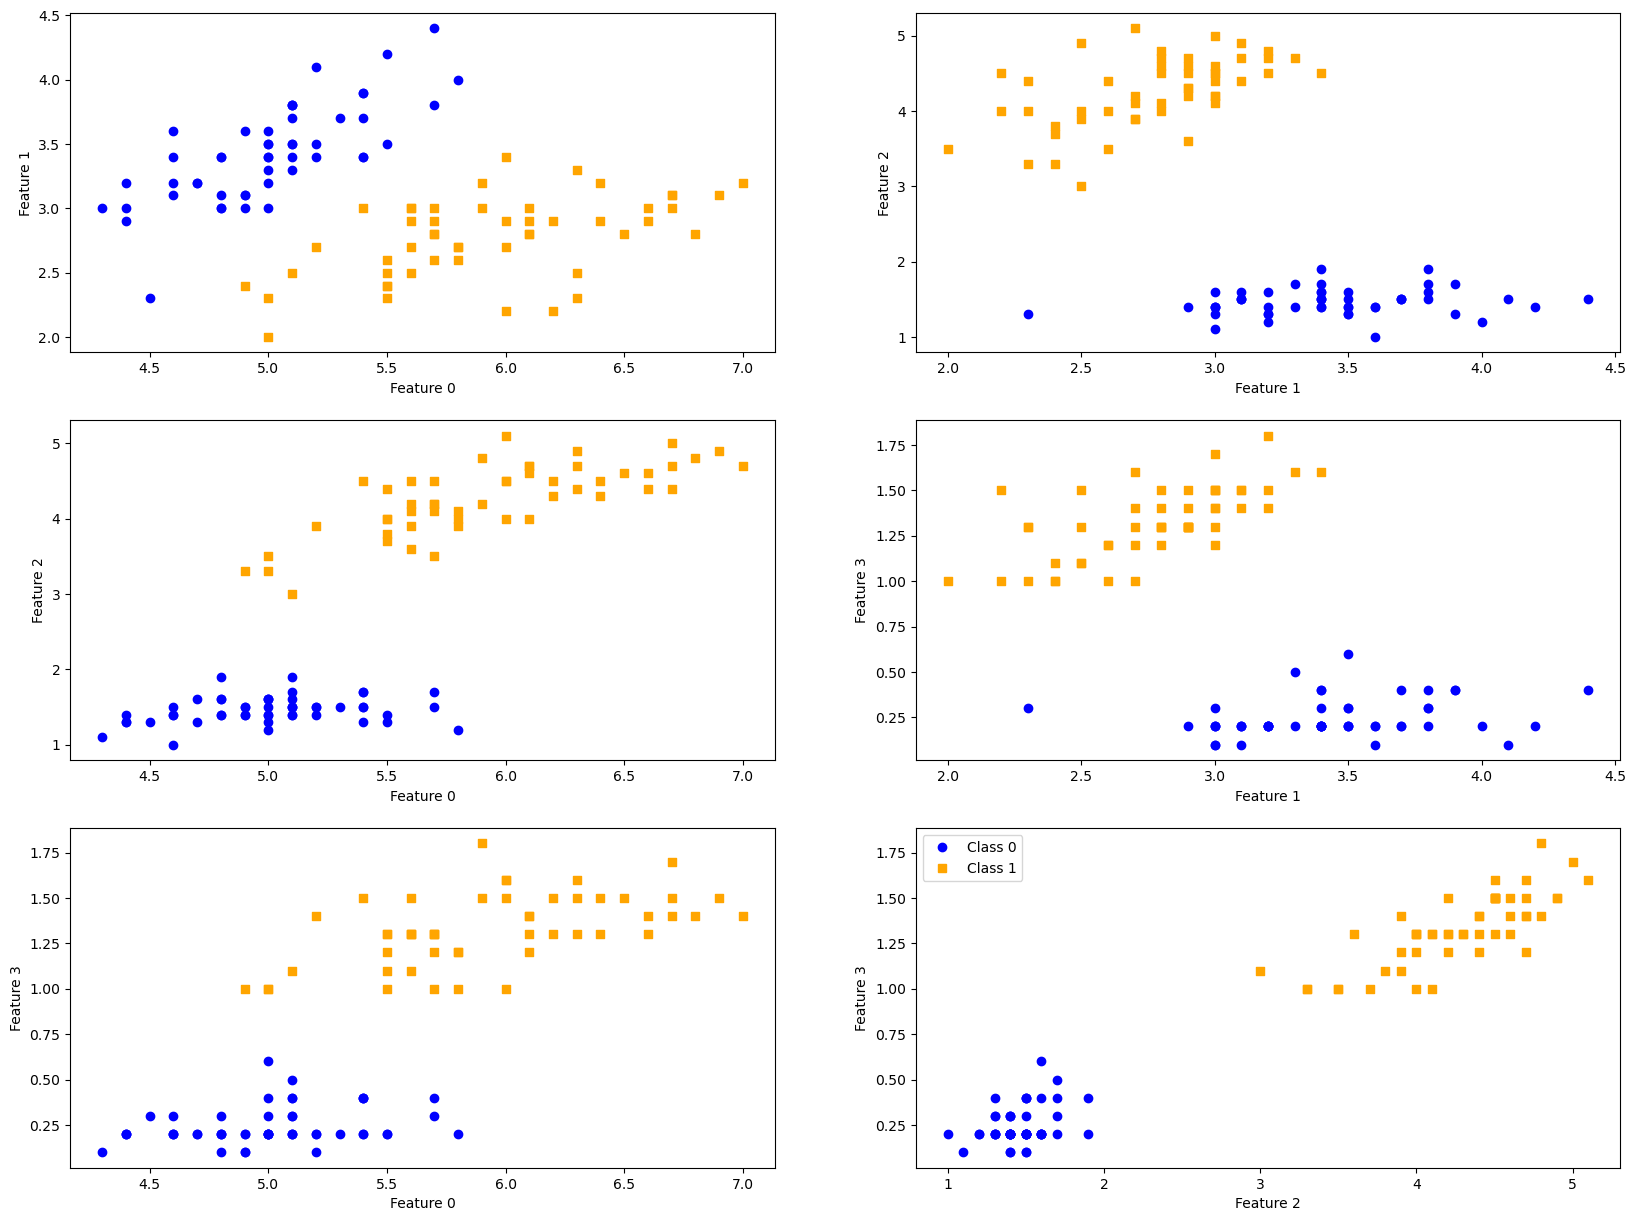

In [2]:
from sklearn import datasets

iris_dataset = datasets.load_iris()
X, y = iris_dataset["data"], iris_dataset["target"]

# We use class 0 and class 1 only, discard class 2
datapoints_in_use = np.bitwise_or(y==0, y==1)
X, y = X[datapoints_in_use], y[datapoints_in_use]

colours = ["blue", "orange"]
markers = ["o", "s"]
indices = [[0, 1], [1, 2], [0, 2], [1, 3], [0, 3], [2, 3]]
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
for k, ax in enumerate(axs.flat):
    for i in range(len(X)):
        ax.scatter(X[i, indices[k][0]], X[i, indices[k][1]], c=colours[y[i]], marker=markers[y[i]])
    ax.set_xlabel(f'Feature {indices[k][0]}')
    ax.set_ylabel(f'Feature {indices[k][1]}')
labels = ['Class 0', 'Class 1']
classes = [plt.Line2D([0], [0], c=c, marker=m, linestyle="None") for c, m in zip(colours, markers)]
axs.flat[-1].legend(classes, labels, loc="upper left")
plt.show()

You should add your code to perform the rescaling, after which the dataset is split into training and testing sets. We have set the ratio of training to testing to 67:33.

In [3]:
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------------------------
# Rescale each column in X
#
# ------------------------------------------------------------------------------
def rescale_to_angles(data):
    # Rescale the data into the range [0, pi]
    return np.pi * data / np.max(data)

# Rescale each column in X to angles
X_angles = rescale_to_angles(X)

# Split the dataset into training and testing sets (67:33)
X_train, X_test, y_train, y_test = train_test_split(X_angles, y, test_size=0.33, random_state=42)






"\nimport numpy as np\n\n# Assuming 'arr' is your 2D numpy array\n#arr = np.array([[0.5, 1.5], [2.5, 3.5]])\narr = X\nprint(np.max(arr))\n# Calculate the minimum and range of the original array\narr_min = np.min(arr)\narr_range = np.max(arr) - arr_min\n\n# Normalize the array to the range [0, 1] and then scale it to the range [0, 2π]\nnormalized_arr = (arr - arr_min) / arr_range\nscaled_arr = normalized_arr * (np.pi/2)\nrescaled_arr =   np.pi*arr / np.max(arr)\nprint(rescaled_arr)    \nprint(rescaled_arr)\n#print(scaled_arr)\n#print(rescaled_arr)\n\n\n\nX_train, X_test, y_train, y_test = train_test_split(rescaled_arr, y, test_size=0.33, random_state=42)\n#print(y_train)"

### 3. Function to create a parametric quantum circuit

You should implement the below function to create a parametric [quantum circuit](https://qiskit.org/documentation/apidoc/circuit.html) as shown in the diagram, with 11 [$R_y$ gates](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.ry.html) and 3 [CNOT gates](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.cx.html). You may want to click on the hyperlinks to navigate to corresponding documentation. In the diagram,  x[0...3] denote the data features, and θ[0...6] denote the trainable parameters. The two sets of parameter values should be given by the function arguments.

At the end, a measurement should be performed on the third qubit. Do *not* measure other qubits, otherwise things will be complicated when you want to read the output in later sections.

The first column of four gates form the **encoding** part of the circuit, where rescaled data features are used as rotation angles. The later part with $θ$s and a measurement is the so-called **ansatz**, where we have a particular structure of gates with trainable parameters. FYI, this ansatz is the [tree tensor network](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.74.022320).

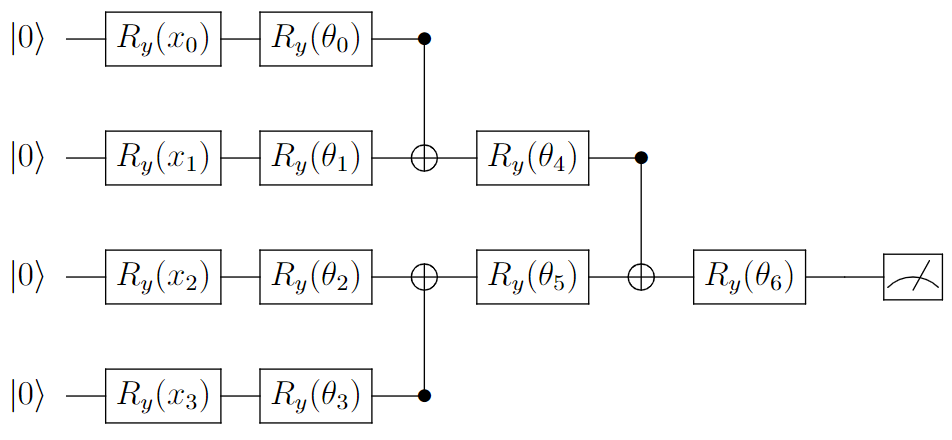


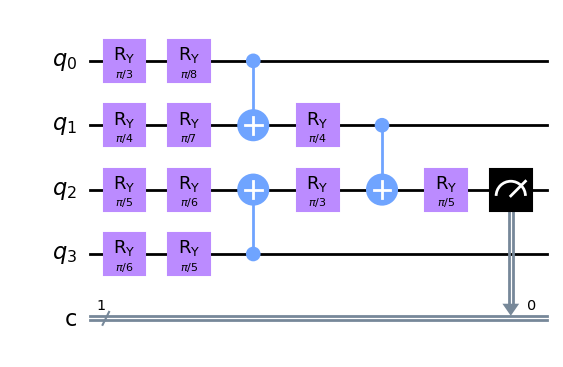

In [4]:
from qiskit import QuantumCircuit
import numpy as np
import math as math

xs =[np.pi/3, np.pi/4, np.pi/5, np.pi/6]
theta = [np.pi/8, np.pi/7, np.pi/6, np.pi/5, np.pi/4, np.pi/3, np.pi/5]

def create_circuit_with_angles(xs, theta):
    """
    Create the parametric circuit with two sets of angles

    Parameters:
        new_xs: np.array(float), should be of length 4
        new_thetas: np.array(float), should be of length 7

    Returns:
        qc_with_fixed_angles: QuantumCircuit, with parameters set to given values
    """
    circ = QuantumCircuit(4,1)
    
    circ.ry(xs[0], 0)
    circ.ry(xs[1] , 1)
    circ.ry(xs[2], 2)
    circ.ry(xs[3], 3)
        
    
    circ.ry(theta[0], 0)
    circ.ry(theta[1], 1)
    circ.ry(theta[2], 2)
    circ.ry(theta[3], 3)

    circ.cx(0,1)
    circ.cx(3,2)

    circ.ry(theta[4],1)
    circ.ry(theta[5],2)

    circ.cx(1,2)
    circ.ry(theta[6], 2)

    circ.measure(2, 0)
    
    
    # --------------------------------------------------------------------------
    # Create the parametric circuit with rotation angles given by arguments
    #
    qc_with_fixed_angles = None
    # --------------------------------------------------------------------------

    return circ



create_circuit_with_angles(xs, theta).draw('mpl')


There are ways to create a parametric circuit and update its parametres on the fly, without the need of creating new circuits each time we want to change the parameters. Take a look at the [`qiskit.circuit.Parameter`](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html) class if you are interested, but this is not required in this exercise.

If you have correctly implemented the function, you should be able to run the below cell and see qiskit drawing a circuit with all $R_y$ gates having random rotation angles. It should look like the following image, but most likely with different random numbers.

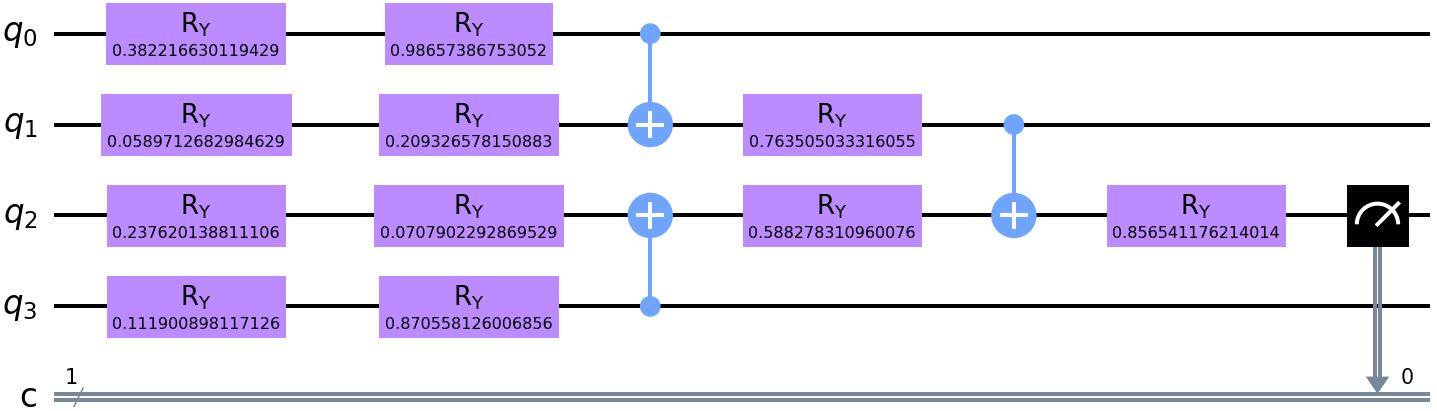

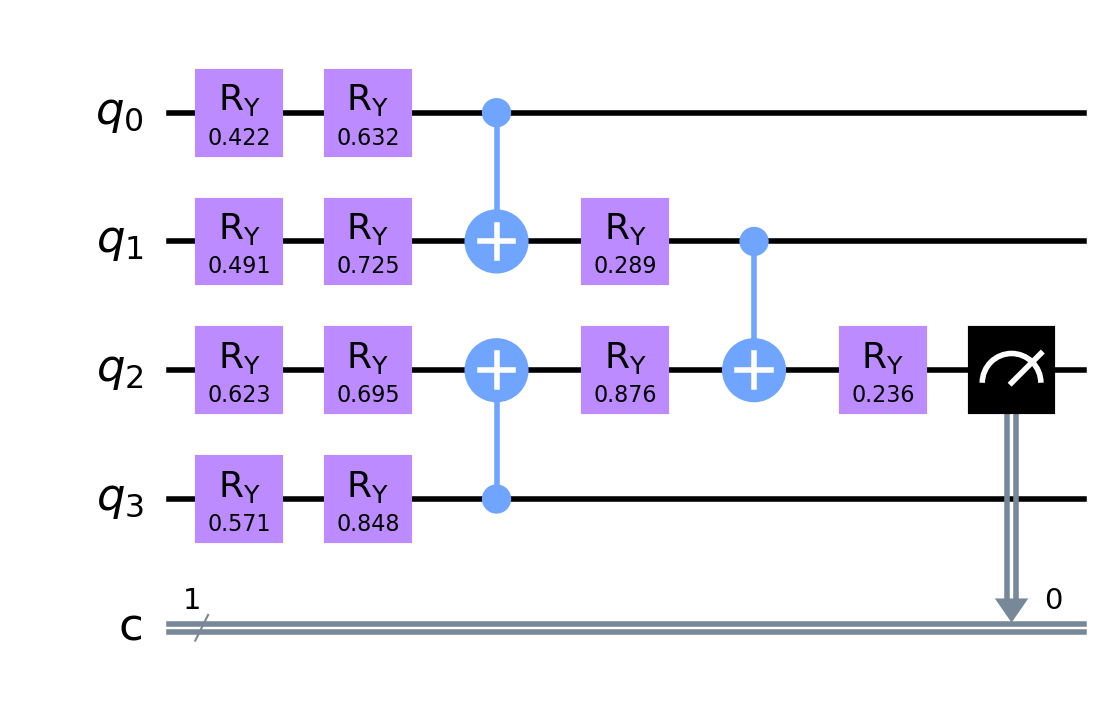

In [5]:
qc_with_random_angles = create_circuit_with_angles(np.random.rand(4), np.random.rand(7))
qc_with_random_angles.draw("mpl", scale=2.0)

### 4. Function to get the probability of getting the |0> state upon measurement

You should implement a function to get the probability that a given quantum circuit outputs the state |0> upon measurement. In this exercise, we are using a simulator to simulate the quantum circuit. It works exactly like a real quantum device - results will be in the form of counts of |0> and |1>, and the counts will depend on how many simulated measurements you ask it to take (i.e., the number of `shots`). Take a look at the documentation of [`simulator.run()`](https://qiskit.org/documentation/stubs/qiskit.providers.aer.QasmSimulator.run.html) and investigate how to extract out the counts from its results and calculate the probability.


In [35]:

from qiskit import Aer
simulator = Aer.get_backend('qasm_simulator')

#simulator= Aer.get_backend('aer_simulator')
#aer_sim = Aer.get_backend('qasm_simulator')

def get_probability_of_zero(qc):
    """
    Parameters:
        qc: QuantumCircuit, which should have a final measurement on one qubit only
        
    Returns:
        p0: float, the probability of getting |0>"""
    job = simulator.run(qc, shots =1000)
    counts = job.result().get_counts()
    if '1' in counts:
        p1= counts['1']/sum(counts.values())
        p0=1-p1
    else:
        p0=1
   
    # --------------------------------------------------------------------------
    # Get the probability of getting |0>
    #
   # p0 = None
    # --------------------------------------------------------------------------
    
    return p0

get_probability_of_zero(qc_with_random_angles)


0.4685

If you want to run the circuit with quantum hardware, e.g., on the IBMQ chips, you simply need to change the backend `Aer.get_backend('qasm_simulator')` into the IBMQ backend, without changing other code.

If you have correctly implemented both `create_circuit_with_angles` and `get_probability_of_zero`, by running the following cells you should be able to see qiskit drawing a new circuit with 0s under all $R_y$, and the probability of getting |0> upon measurement on the third qubit should be 1. (Because effectively all gates are identities!)

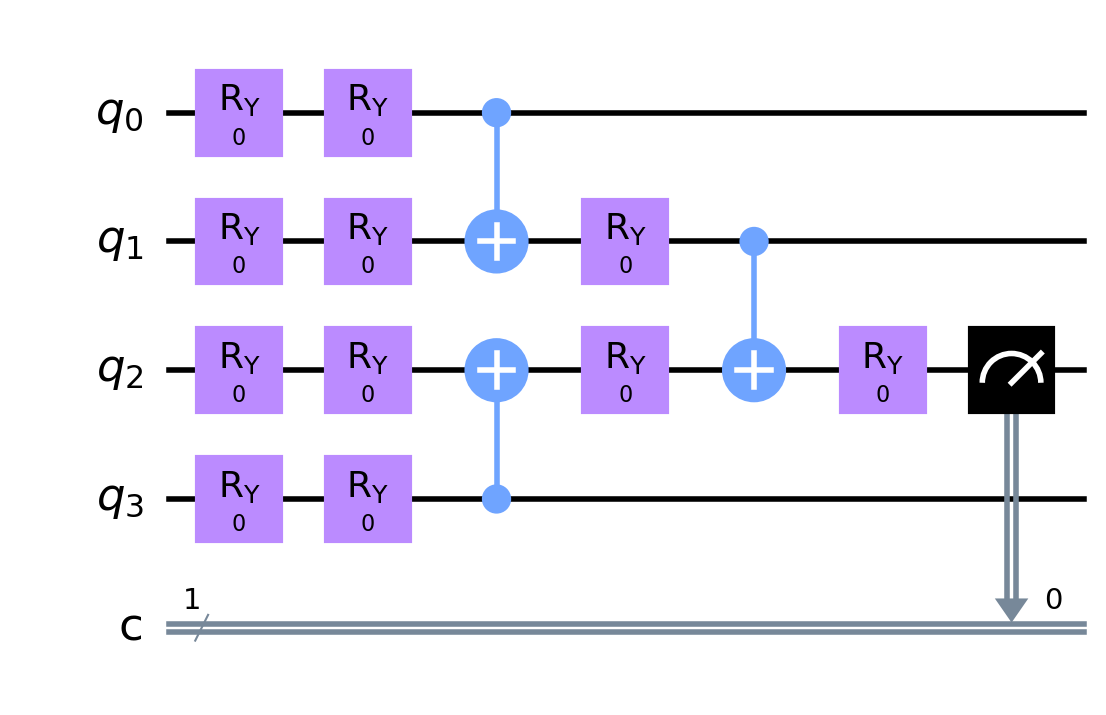

In [36]:
qc_with_zero_angles = create_circuit_with_angles(np.array([0.0 for _ in range(4)]), np.array([0 for _ in range(7)]))
qc_with_zero_angles.draw("mpl", scale=2.0)

In [37]:
print(get_probability_of_zero(qc_with_zero_angles))

1


### 5. Function to calculate the loss function

In this exercise we use the mean squared error loss function. We denote the probability that we get |0> by measuring a specific readout qubit by $p_{(0)}$, the probability that we get |1> by $p_{(1)} = 1 - p_{(0)}$, and the true class label of a data point by $y$ which is either 0 or 1. For each data point the associated loss is:
$$ L = (1-p_{(0)})^2 \:\: \text{if} \:\: y=0 $$
$$ L = (1-p_{(1)})^2 \:\: \text{if} \:\: y=1 $$

Intuitively, for points in class 0, we want |0> to have high probability; for points in class 1, we want |1> to have high probability, thus we want $p$ to be close to 1 in both cases.

The mean squared error loss function is then the sum of all individual loss values, where $N$ is the number of points:
$$ \text{MSE} = \frac{1}{N} \sum^N L $$

For simplicity, in this exercise we calculate MSE for all points in the training dataset. In practice when we would have to deal with very large datasets, we might want to divide the training set into smaller batches to speed up the training process. This is not required in this exercise.

To implement the loss function, you will need to use functions implemented in the previous two sections to calculate a loss based on $p_{(0)}$ for each data point, then summing them up.

In [38]:
import numpy as np

def loss_function(thetas):
    """
    Parameter:
        thetas: np.array(float), should be of length 7
        X_train: np.array, training data
        y_train: np.array, training labels
    
    Returns:
        mean_squared_error_loss: float
    """

    mean_squared_error_loss = 0.0

    # --------------------------------------------------------------------------
    # Calculate loss for each data point, then sum up and take average
    #
    N = len(X_train)
    for data, label in zip(X_train, y_train):
        #print(data)
       # print(label)
        p_0 = get_probability_of_zero(create_circuit_with_angles(data, theta))  # Assuming you have implemented this function
        if label == 0:
            loss = (1 - p_0)**2
           # mean_squared_error_loss += loss
        #if label == 1:
        else:
            #loss = (1 - (1 - p_0))**2
            loss = p_0**2
        mean_squared_error_loss += loss
    mean_squared_error_loss /= N
    # --------------------------------------------------------------------------

    return mean_squared_error_loss


### 6. Minimise the loss function

In this exercise we use off-the-shelf optimiser [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). It will optimise a given loss function with given initial parameters. 

You should take a look at its documentation and try different options of optimisation methods and look for a best one.

The run time will depend on how many measurement shots you use. For example, with 100 shots, the optimisation should typically finish within 1 minute.

In [60]:
%%time

from scipy.optimize import minimize
result = 0
# ------------------------------------------------------------------------------
# Try differnt optimisation methods
#
optimisation_method = 'Powell'
# ------------------------------------------------------------------------------

initial_thetas = np.random.rand(7)
print(initial_thetas)
#result = minimize(loss_function, initial_thetas, method=optimisation_method)
result = minimize(loss_function, initial_thetas, method=optimisation_method)
#result = minimize(loss_function, initial_thetas, method=optimisation_method, )

final_thetas = result.x
print(final_thetas)

[0.38541134 0.38810057 0.38335687 0.07966292 0.34346331 0.99632273
 0.16365343]
[ 0.41548829 -1.58432529  4.91921582 -8.02160623  2.20937239  4.5593311
  4.86256809]
Wall time: 2min 22s


### 7. Plot the classification results

Below we provide code to visualise the outcome of training the prametric quantum circuit. 

If everything is implemented correctly and you have chosen a good optimisation method, you should be able to see most points being green (correctly classified).

Training accuracy: 65/67 = 0.9701492537313433
Testing accuracy: 33/33 = 1.0


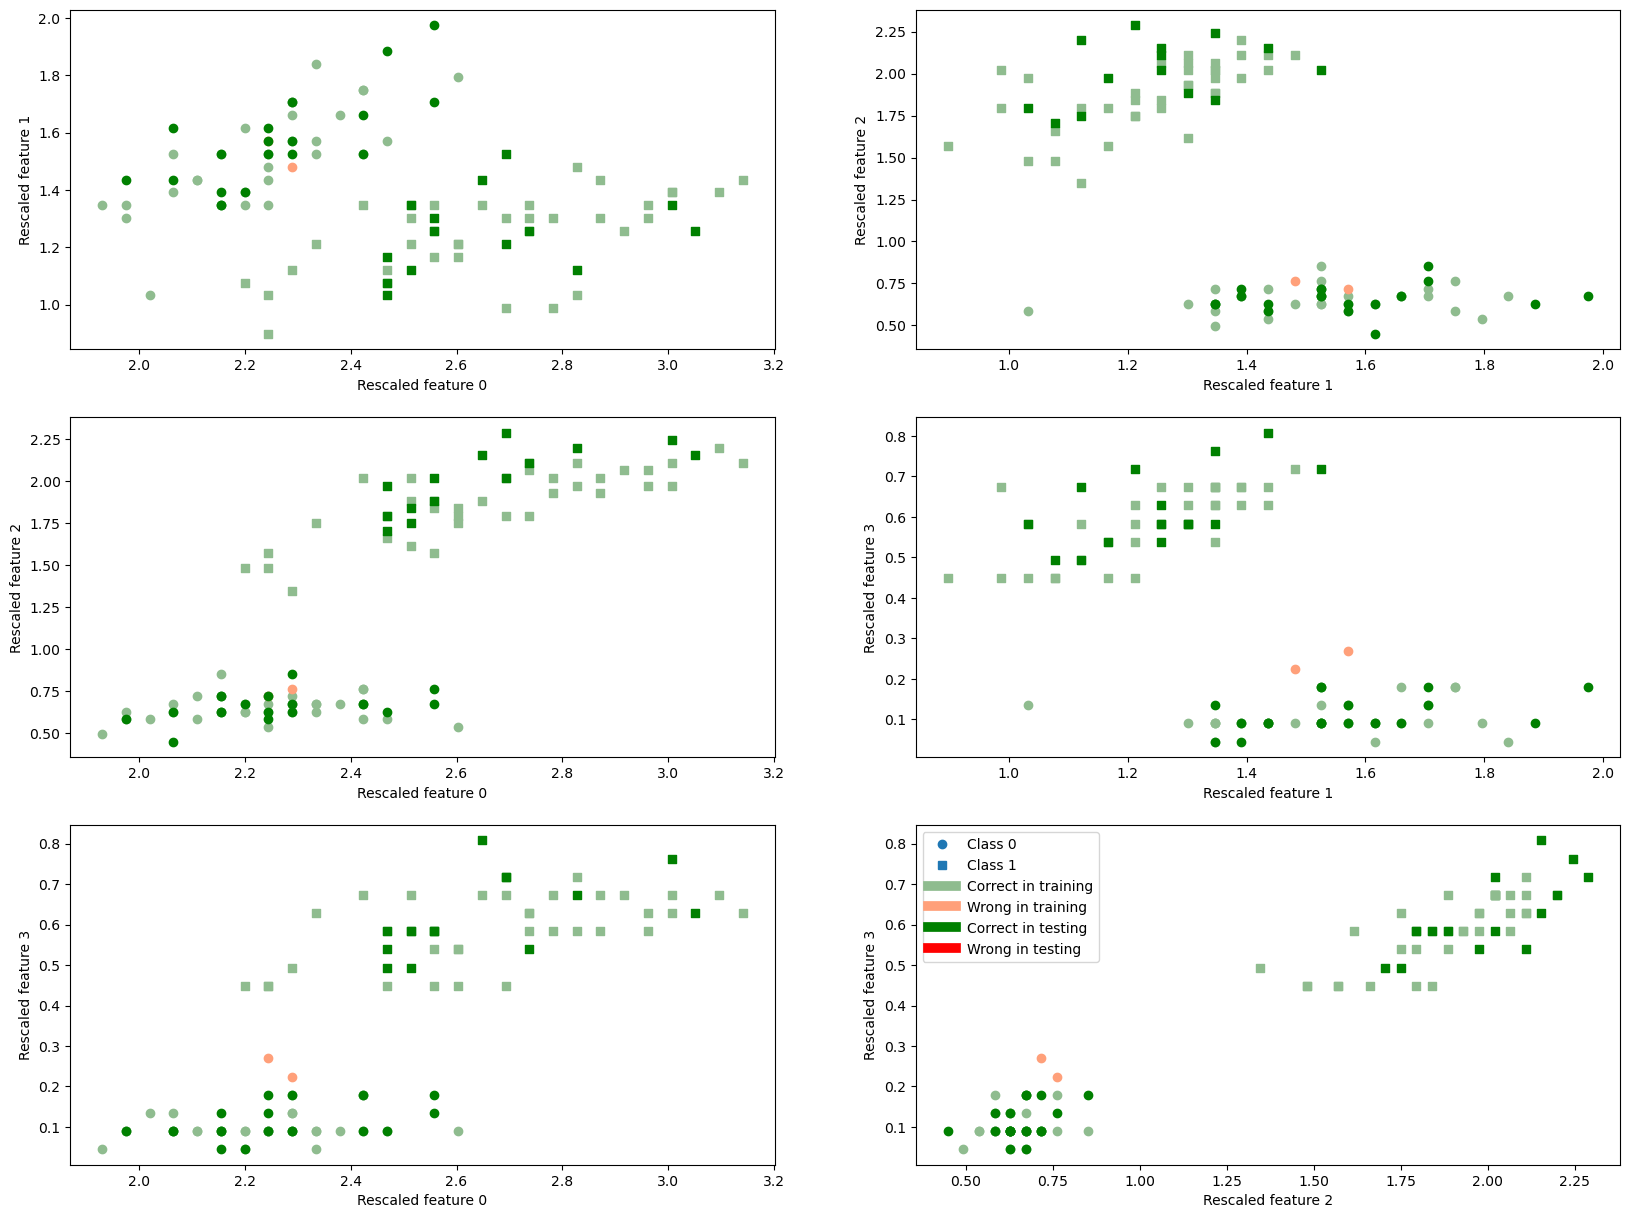

In [61]:
train_correct, test_correct = [], []
for all_data, labels, trues_list in zip([X_train, X_test],
                                        [y_train, y_test],
                                        [train_correct, test_correct]):
    for data, label in zip(all_data, labels):
        probabilities = [0, 0]
        probabilities[0] = get_probability_of_zero(create_circuit_with_angles(data, final_thetas))
        probabilities[1] = 1 - probabilities[0]
        trues_list.append(probabilities.index(max(probabilities)) == label)

print(f"Training accuracy: {sum(train_correct)}/{len(X_train)} = {sum(train_correct)/len(X_train)}")
print(f"Testing accuracy: {sum(test_correct)}/{len(X_test)} = {sum(test_correct)/len(X_test)}")

markers = ["o", "s"]
indices = [[0, 1], [1, 2], [0, 2], [1, 3], [0, 3], [2, 3]]
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
for k, ax in enumerate(axs.flat):
    for i in range(len(X_train)):
        ax.scatter(X_train[i, indices[k][0]], X_train[i, indices[k][1]],
                   c="darkseagreen" if train_correct[i] else "lightsalmon",
                   marker=markers[int(y_train[i])])
    for i in range(len(X_test)):
        ax.scatter(X_test[i, indices[k][0]], X_test[i, indices[k][1]],
                   c="green" if test_correct[i] else "red",
                   marker=markers[int(y_test[i])])
    ax.set_xlabel(f'Rescaled feature {indices[k][0]}')
    ax.set_ylabel(f'Rescaled feature {indices[k][1]}')
colors = ['darkseagreen', 'lightsalmon', 'green', 'red']
labels = ['Class 0', 'Class 1',
          'Correct in training', 'Wrong in training', 'Correct in testing', 'Wrong in testing']
classes = [plt.Line2D([0], [0], marker=m, linestyle="None") for m in markers]
correct_wrong = [plt.Line2D([0], [0], color=c, linewidth=7.0) for c in colors]
axs.flat[-1].legend([*classes, *correct_wrong], labels, loc="upper left")
plt.show()

### 8. Number of shots vs. accuracy

Try to use different numbers of shots for `simulator.run()`, e.g., 5, 10, 100, 1000 shots, and rerun the optimisation process. Could you observe the relationship between the number of shots, the accuracy and the training time?

Shots  | Testing accuracy | Training time
-------|------------------|--------------
5      |                  |
10     |                  |
100    |                  |
1000   |                  |

### 9. Points to think about

In this exercise we have practised to implement a given parametric quantum circuit to solve a particular problem. Here are a few things to think about:

*   The dataset needs to be rescaled to be used as rotation angles. What if there are outliers in the dataset, causing the majority to be scaled to a much smaller range? When we want to make predictions on new data, what if the new data contain outliers?

*   For the Iris dataset, there are 4 features and we use 4 qubits with $R_y$ gates to encode them. Can we use different methods to encode the data? For other datasets where we don't have exactly 4 features, how should we change the structure of the circuit?

*   It's not a *must* that we apply the encoding gates first, then the ansatz. What effect would it have if we insert some encoding gates into the ansatz?

*   $R_y$ rotations are real-valued. Would it be better or worse if we use $R_x$ and $R_z$ gates, or even any arbitrary gate?

*   In the loss function we require $p_{(y)}$ to be close to 1. This works well for binary classification, but it won't work for multi-class classification nor regression. How should the loss function be adapted for different problems?

*   When we run the optimisation, it will be good if we can get the loss value at each iteration, so we can plot a loss curve against the number of training steps. How to do that?

In the next exercise, you will be free to design your own parametric quantum circuit to solve the force field fitting problem. You will need to think about some of the above aspects and try different things, in order to achieve a good solution.


